## Deep Learning from Zero 2



In [115]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [89]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    #assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': 'LR'}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name = str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [150]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        # other = other if isinstance(other, Value) else Value(other)
        assert isinstance(other, (int, float)), "only supporting int/float powes for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data**(other - 1)) * out.grad
        
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # other * self
        return self * other    
        
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other): # self - other
        return self + (-other)
        
    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [43]:
# input x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88137358, label='b')

# z = x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

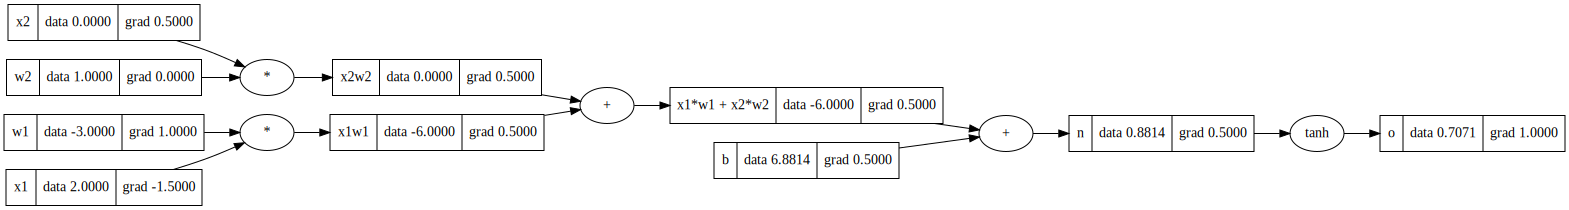

In [44]:
draw_dot(o)

$tanh\,x = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{e^{2x} - 1}{e^{2x} + 1}$

In [7]:
# input x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88137358, label='b')

# z = x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# --
e = (2*n).exp()
o = (e - 1) / (e + 1)
# --
o.label = 'o'
o.backward()
draw_dot(o)

NameError: name 'draw_dot' is not defined

In [47]:
import torch

In [55]:

x1 = torch.Tensor([2.0]).double()                ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ;b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [57]:
o.item()

0.7071066904050358

In [58]:
x1.grad

tensor([-1.5000], dtype=torch.float64)

In [53]:
torch.Tensor([2.0]).double().dtype

torch.float64

### Build the Multi-layer perceptron (Model MLP):

In [31]:
class Neuron:
    
    def __init__(self, nin):
        # nin:dimension of the neuron inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        print(list(zip(self.w, x)))
        return 0.0

x = [2.0, 3.0]
# initialize a neuron that is two-demensional.
n = Neuron(2)
# feed thost two numbers into that neuron to get an output.
n(x)

[(Value(data=-0.4629787353239705), 2.0), (Value(data=0.9797180858758985), 3.0)]


0.0

In [72]:
class Neuron:
    
    def __init__(self, nin):
        # nin:dimension of the neuron inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        # zip:take iterators and creates a new iterators 
        # over the tuples of corresponding entries.
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
    
    # nin:numbers of inputs in the layer
    # nout:number of outputs in the layer
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

x = [2.0, 3.0]
n = Layer(2,3)
# we have three independent evaluations of three different neurons.
n(x)

[Value(data=0.2751774771647183),
 Value(data=0.08807623729212599),
 Value(data=-0.10313002635414234)]

In [162]:

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out
    
    def parameters(self):
        # returns the parameters tensors (scaler):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        '''
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extends(ps)
        return params
        '''
        
class MLP:
    
    # nin:number of inputs in the neuron
    # nouts:take list of nouts,and list defines the sizes of all the layers that we want in MLP
    def __init__(self, nin, nouts):
        # sz:size 
        sz = [nin] + nouts
        print(sz)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [225]:
# initialize the MLP
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

[3, 4, 4, 1]


Value(data=0.908880941931081)

In [226]:
n.parameters()

[Value(data=0.5522239418629378),
 Value(data=-0.42458483259775637),
 Value(data=0.9418642167208735),
 Value(data=0.7741138368342089),
 Value(data=0.6916163017716799),
 Value(data=0.45229505206464804),
 Value(data=0.11208817824315687),
 Value(data=-0.34245015484661057),
 Value(data=0.5245274482024627),
 Value(data=-0.3244372594404892),
 Value(data=-0.46912670914063836),
 Value(data=0.5097545529709484),
 Value(data=-0.030671459526405043),
 Value(data=0.8453387752977886),
 Value(data=0.37246058215091193),
 Value(data=-0.9539319535232371),
 Value(data=-0.135265346160649),
 Value(data=-0.8309951137520164),
 Value(data=-0.5018516454748898),
 Value(data=-0.39460713190239427),
 Value(data=0.20285707088681937),
 Value(data=0.6937853735908681),
 Value(data=-0.8734522257145192),
 Value(data=0.12588139948215327),
 Value(data=0.5173921455522288),
 Value(data=-0.35710739734873354),
 Value(data=0.526323656570693),
 Value(data=-0.7535808433445574),
 Value(data=-0.7732073771400656),
 Value(data=-0.6431

In [227]:
# dataset for simple binary classifier neural net
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0 ],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [281]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward() # attention! remember to write the '__radd__' method in class Value

    # update
    # we actually want to change parameters slightly to the gradient information 
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)
    

0 0.004945225303503612
1 0.004908276729419514
2 0.004871849190593106
3 0.004835931960487601
4 0.004800514601765837
5 0.004765586956677536
6 0.004731139137825441
7 0.004697161519293466
8 0.004663644728120123
9 0.004630579636101787
10 0.00459795735191115
11 0.004565769213516755
12 0.004534006780890424
13 0.004502661828989882
14 0.00447172634100455
15 0.004441192501853264
16 0.004411052691922828
17 0.004381299481037198
18 0.004351925622647747
19 0.004322924048234705


In [282]:
ypred

[Value(data=0.9670979387526897),
 Value(data=-0.9670510114060061),
 Value(data=-0.9661978261684231),
 Value(data=0.9681856068923881)]

In [278]:
n.parameters()

[Value(data=0.3417232594883229),
 Value(data=-0.6280619624684621),
 Value(data=1.2416756424446067),
 Value(data=0.5987462296012234),
 Value(data=0.48699712472977835),
 Value(data=0.5098500532151813),
 Value(data=0.040124963840018395),
 Value(data=-0.4200054411164173),
 Value(data=0.4908297968060316),
 Value(data=-0.37506930014598205),
 Value(data=-0.5974068275514017),
 Value(data=0.4440480515473346),
 Value(data=0.0291996983496523),
 Value(data=0.9516298757285496),
 Value(data=0.3142123870865723),
 Value(data=-0.8571062755121187),
 Value(data=-0.5647590535554344),
 Value(data=-0.8999492337005436),
 Value(data=-0.4345077512568023),
 Value(data=-0.34535456161884476),
 Value(data=0.05409701154000706),
 Value(data=0.9877035462717063),
 Value(data=-0.7531493615229028),
 Value(data=0.19179860116259614),
 Value(data=0.4210596366424864),
 Value(data=-0.13967713374811339),
 Value(data=1.1306739356634077),
 Value(data=-0.5826157539614932),
 Value(data=-0.75770333834543),
 Value(data=-0.762796759